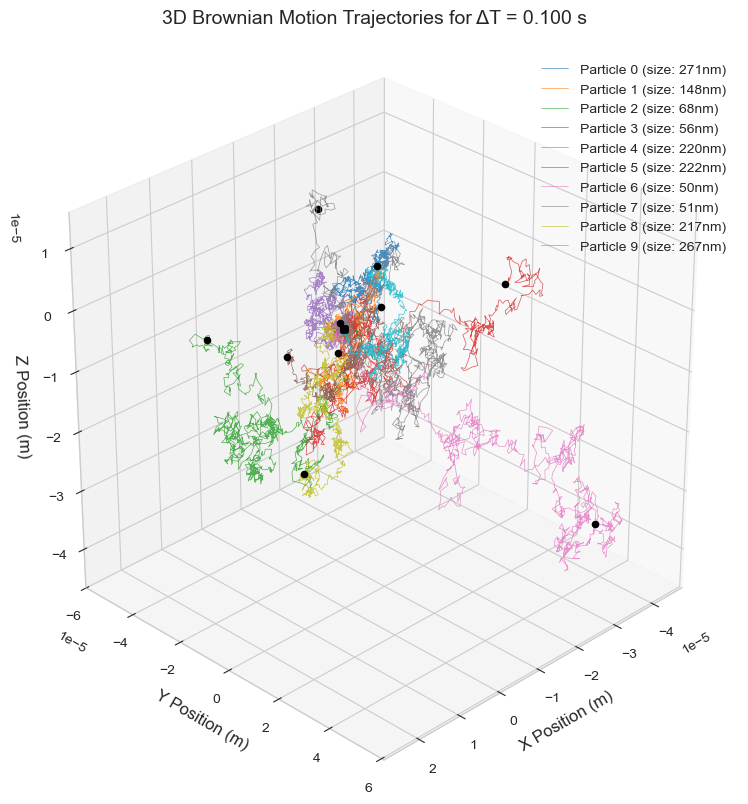

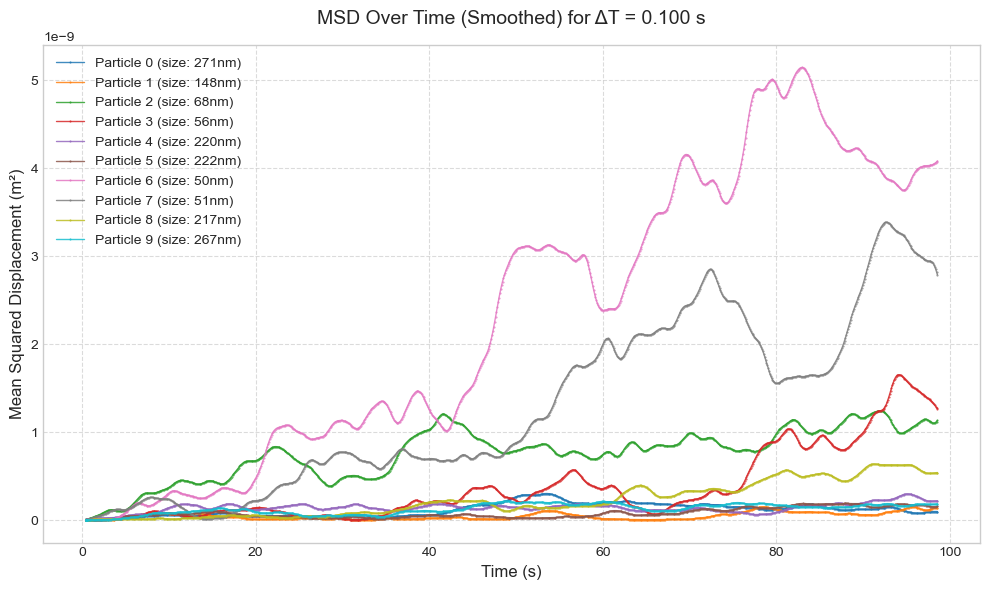

In [ ]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

# Use a clean style for plots
plt.style.use('seaborn-v0_8-whitegrid')

# Folder where the CSV files are located
folder_path = r"D:/Thesis_Workspace/Main_Cplusplus/brownian_v1.6_copy_oneInterval/notFinal"  # Adjust as needed

def format_particle_size(size):
    """
    Convert a particle size from meters to nanometers and return a string in layman's terms.
    For example, if the particle size is 2.8e-8 m, it returns "28nm".
    If the conversion fails, returns "Unknown".
    """
    try:
        size_float = float(size)
        size_nm = size_float * 1e9  # Convert meters to nanometers
        return f"{size_nm:.0f}nm"
    except (ValueError, TypeError):
        return "Unknown"

#############################################
# 1. 3D Trajectory Plots per ΔT             #
#############################################

# Find files that start with "traj_dt" and end with ".csv"
traj_pattern = os.path.join(folder_path, "traj_dt*.csv")
traj_csv_files = glob.glob(traj_pattern)

if not traj_csv_files:
    print("No trajectory CSV files found in:", folder_path)
else:
    # Group files by ΔT value extracted from filename (e.g. "traj_dt0.01.csv")
    dt_groups = {}
    for csv_file in traj_csv_files:
        basename = os.path.basename(csv_file)
        dt_val = basename.replace("traj_dt", "").replace(".csv", "")
        dt_groups.setdefault(dt_val, []).append(csv_file)

    for dt_val in sorted(dt_groups.keys(), key=lambda x: float(x)):
        # Combine all trajectory data for this ΔT value
        df_all = pd.concat([pd.read_csv(f) for f in dt_groups[dt_val]], ignore_index=True)
        
        # Group data by particle; each group contains all trajectory points for that particle.
        grouped = df_all.groupby("particle")
        particles = sorted(df_all["particle"].unique())
        cmap = plt.get_cmap("tab10", len(particles))
        particle_colors = {p: cmap(i) for i, p in enumerate(particles)}
        
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection="3d")
        
        # Plot each particle's trajectory.
        for p, group in grouped:
            if "time" in group.columns:
                group = group.sort_values("time")
            raw_size = group["particle_size"].iloc[0] if "particle_size" in group.columns else None
            particle_size = format_particle_size(raw_size) if raw_size is not None else "Unknown"
            label = f"Particle {p} (size: {particle_size})"
            
            ax.plot(group["x"], group["y"], group["z"],
                    color=particle_colors[p], alpha=0.8, linewidth=0.5,
                    label=label)
            # Mark the starting point (yellow square)
            ax.scatter(group["x"].iloc[0],
                       group["y"].iloc[0],
                       group["z"].iloc[0],
                       color="black", marker="s", s=20, zorder=5)
            # Mark the ending point (black circle)
            ax.scatter(group["x"].iloc[-1],
                       group["y"].iloc[-1],
                       group["z"].iloc[-1],
                       color="black", marker="o", s=20, zorder=5)
        
        ax.set_xlabel("X Position (m)", fontsize=12)
        ax.set_ylabel("Y Position (m)", fontsize=12)
        ax.set_zlabel("Z Position (m)", fontsize=12)
        ax.set_title(f"3D Brownian Motion Trajectories for ΔT = {float(dt_val):.3f} s", 
                     fontsize=14, pad=20)
        ax.view_init(elev=30, azim=45)
        try:
            ax.set_box_aspect((1, 1, 1))
        except Exception:
            pass
        ax.legend(fontsize=10)
        fig.tight_layout()
        # Optionally, save the figure:
        # fig.savefig(f"trajectory_dt_{dt_val}.png", dpi=300)

#############################################
# 2. MSD Line Charts per ΔT                 #
#############################################

# Find files that start with "msd_dt" and end with ".csv"
msd_pattern = os.path.join(folder_path, "msd_dt*.csv")
msd_files = glob.glob(msd_pattern)

def smooth_data(series, window=10, iterations=3):
    """Smooths a data series using a rolling mean."""
    for _ in range(iterations):
        series = series.rolling(window=window).mean().bfill()
    return series

if not msd_files:
    print("No MSD CSV files found in:", folder_path)
else:
    # Group MSD files by ΔT value (e.g. "msd_dt0.01.csv")
    msd_dt_groups = {}
    for msd_file in msd_files:
        basename = os.path.basename(msd_file)
        dt_val = basename.replace("msd_dt", "").replace(".csv", "")
        msd_dt_groups.setdefault(dt_val, []).append(msd_file)
    
    for dt_val in sorted(msd_dt_groups.keys(), key=lambda x: float(x)):
        # Combine all MSD data for this ΔT value
        df_msd_all = pd.concat([pd.read_csv(f) for f in msd_dt_groups[dt_val]], ignore_index=True)
        fig, ax = plt.subplots(figsize=(10, 6))
        
        if "particle" in df_msd_all.columns:
            # Plot each particle separately.
            particles = sorted(df_msd_all["particle"].unique())
            cmap = plt.get_cmap("tab10", len(particles))
            particle_colors = {p: cmap(i) for i, p in enumerate(particles)}
            for p, group in df_msd_all.groupby("particle"):
                group = group.sort_values("time").copy()
                group["smoothed_time"] = smooth_data(group["time"])
                group["smoothed_msd"] = smooth_data(group["msd"])
                raw_size = group["particle_size"].iloc[0] if "particle_size" in group.columns else None
                particle_size = format_particle_size(raw_size) if raw_size is not None else "Unknown"
                ax.plot(group["smoothed_time"], group["smoothed_msd"],
                        color=particle_colors[p],
                        label=f"Particle {p} (size: {particle_size})",
                        linewidth=1, marker='o', markersize=0.5, alpha=0.85)
        else:
            # Otherwise, plot a single curve for the entire ΔT group.
            df_msd_all["smoothed_time"] = smooth_data(df_msd_all["time"])
            df_msd_all["smoothed_msd"] = smooth_data(df_msd_all["msd"])
            ax.plot(df_msd_all["smoothed_time"], df_msd_all["smoothed_msd"],
                    label=f"MSD dt={dt_val}", linewidth=1, marker='o', markersize=0.5, alpha=0.85)
        
        ax.set_xlabel("Time (s)", fontsize=12)
        ax.set_ylabel("Mean Squared Displacement (m²)", fontsize=12)
        ax.set_title(f"MSD Over Time (Smoothed) for ΔT = {float(dt_val):.3f} s", fontsize=14, pad=15)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(fontsize=10)
        fig.tight_layout()
        # Optionally, save the figure:
        # fig.savefig(f"msd_dt_{dt_val}.png", dpi=300)

# Finally, display all figures.
plt.show()


   run  num_particles  num_steps  run_time_s
0    0             10       1000    0.254570
1    1             10       2000    0.519339
2    2             10       3000    0.780157
3    3             10       4000    1.065640
4    4             10       5000    1.353640
Fitted parameters: [13.40921731 52.75680352 24.76509943]

Metrics:
SSE (Error Sum of Squares): 11.786055195824572
MSE (Mean Square Error): 0.2507671318260547
R-squared: 0.9854913846293265
p-value: 1.1102230246251565e-16


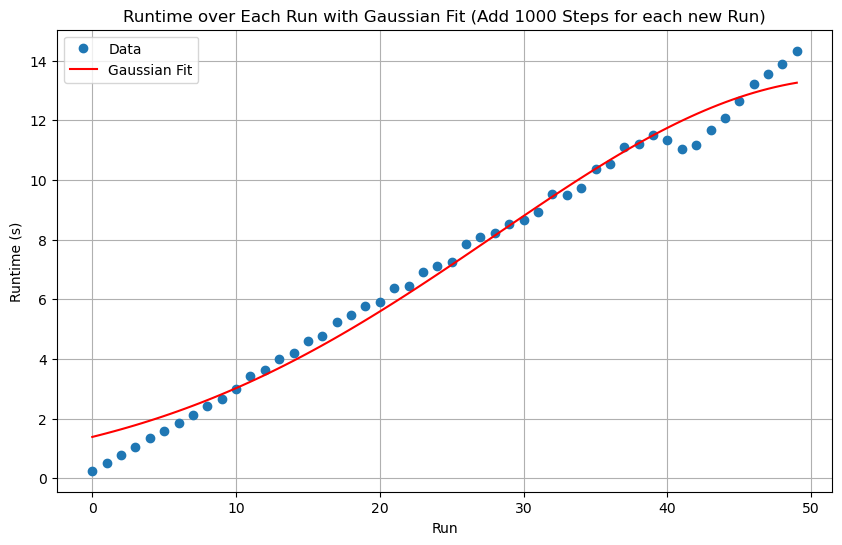

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import scipy.stats as stats  # For p-value computation

# Read the CSV file
df = pd.read_csv(r"D:\Thesis_Workspace\Python_Plotting\3d\Add1000StepsBenchmark.csv")
print(df.head())

# Define the Gaussian function
def gaussian(x, a, mu, sigma):
    return a * np.exp(-((x - mu)**2) / (2 * sigma**2))

# Fit the Gaussian model to your data
params, _ = curve_fit(gaussian, df['run'], df['run_time_s'])
print("Fitted parameters:", params)

# Calculate predicted y values for the original x values
y_pred = gaussian(df['run'], *params)

# Compute SSE (Error Sum of Squares)
residuals = df['run_time_s'] - y_pred
ss_res = np.sum(residuals**2)  # SSE

# Compute R-squared
ss_tot = np.sum((df['run_time_s'] - np.mean(df['run_time_s']))**2)
r_squared = 1 - (ss_res / ss_tot)

# Compute MSE (Mean Square Error)
n = len(df['run_time_s'])  # Number of observations
p = len(params)            # Number of parameters in the model
df_error = n - p           # Degrees of freedom for the error
mse = ss_res / df_error

# Compute p-value
# Calculate SSR and then MSR, F-statistic and finally the p-value.
ssr = ss_tot - ss_res
df_model = p - 1
msr = ssr / df_model
f_stat = msr / mse
p_value = 1 - stats.f.cdf(f_stat, df_model, df_error)

# Print only the required metrics
print("\nMetrics:")
print("SSE (Error Sum of Squares):", ss_res)
print("MSE (Mean Square Error):", mse)
print("R-squared:", r_squared)
print("p-value:", p_value)

# Generate x-values for the fitted curve
x_fit = np.linspace(df['run'].min(), df['run'].max(), 100)
y_fit = gaussian(x_fit, *params)

# Plot the original data and the Gaussian fit
plt.figure(figsize=(10, 6))
plt.plot(df['run'], df['run_time_s'], marker='o', linestyle='', label='Data')
plt.plot(x_fit, y_fit, 'r-', label='Gaussian Fit')
plt.xlabel('Run')
plt.ylabel('Runtime (s)')
plt.title('Runtime over Each Run with Gaussian Fit (Add 1000 Steps for each new Run)')
plt.legend()
plt.grid(True)
plt.show()


   run  num_particles  num_steps  run_time_s
0    0             10       1000    0.221660
1    1             20       1000    0.590956
2    2             30       1000    1.005270
3    3             40       1000    1.314640
4    4             50       1000    1.660770
Fitted parameters: [18.79000382 56.24728833 25.73787298]

Metrics:
SSE (Error Sum of Squares): 13.235650771305842
MSE (Mean Square Error): 0.2816095908788477
R-squared: 0.990928534197225
p-value: 1.1102230246251565e-16


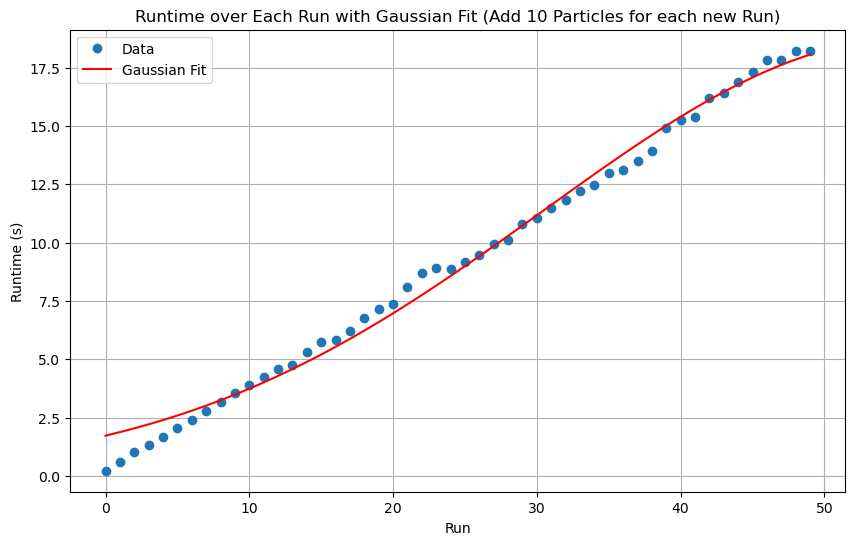

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import scipy.stats as stats  # For p-value computation

# Read the CSV file
df = pd.read_csv(r"D:\Thesis_Workspace\Python_Plotting\3d\Add10Particlesbenchmark.csv")
print(df.head())

# Define the Gaussian function
def gaussian(x, a, mu, sigma):
    return a * np.exp(-((x - mu)**2) / (2 * sigma**2))

# Fit the Gaussian model to your data
params, _ = curve_fit(gaussian, df['run'], df['run_time_s'])
print("Fitted parameters:", params)

# Calculate predicted y values for the original x values
y_pred = gaussian(df['run'], *params)

# Compute SSE (Error Sum of Squares)
residuals = df['run_time_s'] - y_pred
ss_res = np.sum(residuals**2)  # SSE

# Compute R-squared
ss_tot = np.sum((df['run_time_s'] - np.mean(df['run_time_s']))**2)
r_squared = 1 - (ss_res / ss_tot)

# Compute MSE (Mean Square Error)
n = len(df['run_time_s'])  # Number of observations
p = len(params)            # Number of parameters in the model
df_error = n - p           # Degrees of freedom for the error
mse = ss_res / df_error

# Compute p-value
# Calculate SSR and then MSR, F-statistic and finally the p-value.
ssr = ss_tot - ss_res
df_model = p - 1
msr = ssr / df_model
f_stat = msr / mse
p_value = 1 - stats.f.cdf(f_stat, df_model, df_error)

# Print only the required metrics
print("\nMetrics:")
print("SSE (Error Sum of Squares):", ss_res)
print("MSE (Mean Square Error):", mse)
print("R-squared:", r_squared)
print("p-value:", p_value)

# Generate x-values for the fitted curve
x_fit = np.linspace(df['run'].min(), df['run'].max(), 100)
y_fit = gaussian(x_fit, *params)

# Plot the original data and the Gaussian fit
plt.figure(figsize=(10, 6))
plt.plot(df['run'], df['run_time_s'], marker='o', linestyle='', label='Data')
plt.plot(x_fit, y_fit, 'r-', label='Gaussian Fit')
plt.xlabel('Run')
plt.ylabel('Runtime (s)')
plt.title('Runtime over Each Run with Gaussian Fit (Add 10 Particles for each new Run)')
plt.legend()
plt.grid(True)
plt.show()


   run  num_particles  num_steps  run_time_s
0    0             10        100    0.067965
1    1             20        200    0.105240
2    2             30        300    0.196109
3    3             40        400    0.313968
4    4             50        500    0.406731
Fitted parameters: [140.9282052  123.95005741  42.65003614]

Metrics:
SSE (Error Sum of Squares): 278.16910757921704
MSE (Mean Square Error): 2.8677227585486293
R-squared: 0.9979619789712655
p-value: 1.1102230246251565e-16


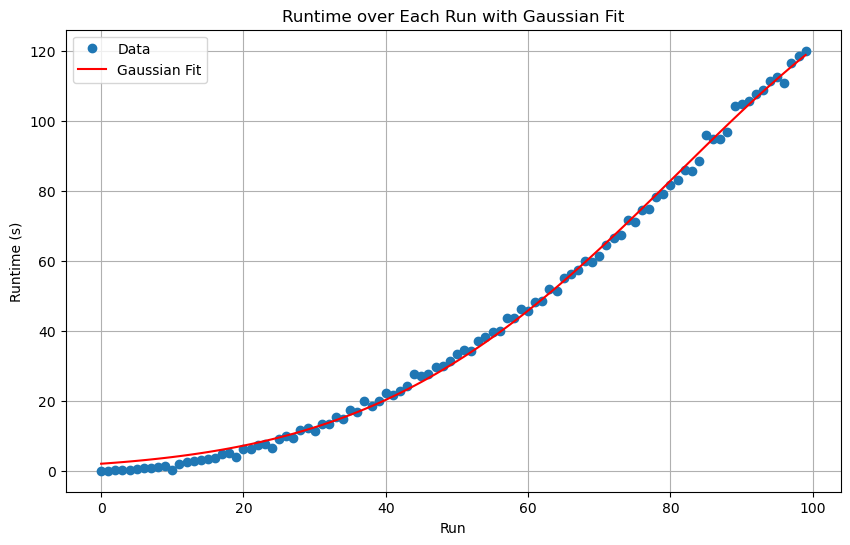

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import scipy.stats as stats  # For p-value computation

# Read the CSV file
df = pd.read_csv(r"D:\Thesis_Workspace\Python_Plotting\3d\benchmark_100runs_10particles_100steps.csv")
print(df.head())

# Define the Gaussian function
def gaussian(x, a, mu, sigma):
    return a * np.exp(-((x - mu)**2) / (2 * sigma**2))

# Fit the Gaussian model to your data
params, _ = curve_fit(gaussian, df['run'], df['run_time_s'])
print("Fitted parameters:", params)

# Calculate predicted y values for the original x values
y_pred = gaussian(df['run'], *params)

# Compute SSE (Error Sum of Squares)
residuals = df['run_time_s'] - y_pred
ss_res = np.sum(residuals**2)  # SSE

# Compute R-squared
ss_tot = np.sum((df['run_time_s'] - np.mean(df['run_time_s']))**2)
r_squared = 1 - (ss_res / ss_tot)

# Compute MSE (Mean Square Error)
n = len(df['run_time_s'])  # Number of observations
p = len(params)            # Number of parameters in the model
df_error = n - p           # Degrees of freedom for the error
mse = ss_res / df_error

# Compute p-value
# Calculate SSR and then MSR, F-statistic and finally the p-value.
ssr = ss_tot - ss_res
df_model = p - 1
msr = ssr / df_model
f_stat = msr / mse
p_value = 1 - stats.f.cdf(f_stat, df_model, df_error)

# Print only the required metrics
print("\nMetrics:")
print("SSE (Error Sum of Squares):", ss_res)
print("MSE (Mean Square Error):", mse)
print("R-squared:", r_squared)
print("p-value:", p_value)

# Generate x-values for the fitted curve
x_fit = np.linspace(df['run'].min(), df['run'].max(), 100)
y_fit = gaussian(x_fit, *params)

# Plot the original data and the Gaussian fit
plt.figure(figsize=(10, 6))
plt.plot(df['run'], df['run_time_s'], marker='o', linestyle='', label='Data')
plt.plot(x_fit, y_fit, 'r-', label='Gaussian Fit')
plt.xlabel('Run')
plt.ylabel('Runtime (s)')
plt.title('Runtime over Each Run with Gaussian Fit')
plt.legend()
plt.grid(True)
plt.show()
